In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from jinja2 import Environment, BaseLoader
import athena

In [53]:
pd.set_option("display.max.columns", None)

In [9]:
sql_template = """
UNLOAD (
SELECT 
    u.machine_id,
    u.url_idc, 
    u.person_id, 
    u.ss2k, 
    u.time_id, 
    u.domain_name, 
    u.url_host, 
    u.url_dir, 
    u.url_page, 
    u.url_refer_domain, 
    u.url_refer_host, 
    u.url_refer_dir, 
    u.url_refer_page, 
    u.mimetype, 
    u.http_rc, 
    u.keywords, 
    u.html_title, 
    u.pattern_id
FROM "comscore"."url" as u
WHERE 
    u.year='{{year}}'
    and u.month='{{month}}'
    and u.day='{{day}}'
    and (u.domain_name LIKE '%twitch%')
) 
TO 's3://kdc-comscore/parquet-extracts/url_twitch_test/year={{year}}/month={{month}}/day={{day}}' 
WITH ( format = 'parquet', compression = 'snappy' )
"""

template = Environment(loader=BaseLoader()).from_string(sql_template)

In [58]:
%%time

results = athena.run_daily(
    "kdc-admin",
    "us-east-2",
    template,
    start_date = dt.datetime(2019, 1, 1),
    end_date = dt.datetime(2019, 1, 14),
    database = "comscore",
    args = {
    },
    batch_size = 50
)
print(f"number of results: {len(results)}")

################################################################################
# executing for date range: ('2019', '01', '01') -> ('2019', '01', '14')
################################################################################
('2019', '01', '01'): STARTED
('2019', '01', '02'): STARTED
('2019', '01', '03'): STARTED
('2019', '01', '04'): STARTED
('2019', '01', '05'): STARTED
('2019', '01', '06'): STARTED
('2019', '01', '07'): STARTED
('2019', '01', '08'): STARTED
('2019', '01', '09'): STARTED
('2019', '01', '10'): STARTED
('2019', '01', '11'): STARTED
('2019', '01', '12'): STARTED
('2019', '01', '13'): STARTED
('2019', '01', '14'): STARTED
>>> Running: 12, Completed: 2
>>> Running: 9, Completed: 5
>>> Running: 5, Completed: 9
>>> Running: 2, Completed: 12
>>> Running: 1, Completed: 13
>>> Running: 0, Completed: 14
number of results: 14
CPU times: user 685 ms, sys: 68.7 ms, total: 753 ms
Wall time: 20.9 s


In [59]:
! aws s3 sync s3://kdc-comscore/parquet-extracts/url_twitch_test ./output/parquet/url_twitch_test --profile kdc-admin

download: s3://kdc-comscore/parquet-extracts/url_twitch_test/year=2019/month=01/day=03/20230117_193256_00007_wazde_099fef8b-8cf0-48d7-a6b1-f813ba65b430 to output/parquet/url_twitch_test/year=2019/month=01/day=03/20230117_193256_00007_wazde_099fef8b-8cf0-48d7-a6b1-f813ba65b430
download: s3://kdc-comscore/parquet-extracts/url_twitch_test/year=2019/month=01/day=03/20230117_193256_00007_wazde_e8d76b5d-30d3-43b6-b850-a97c9d3ed506 to output/parquet/url_twitch_test/year=2019/month=01/day=03/20230117_193256_00007_wazde_e8d76b5d-30d3-43b6-b850-a97c9d3ed506
download: s3://kdc-comscore/parquet-extracts/url_twitch_test/year=2019/month=01/day=03/20230117_193256_00007_wazde_b58bb88f-7267-43fc-bd7e-c3220c61e44d to output/parquet/url_twitch_test/year=2019/month=01/day=03/20230117_193256_00007_wazde_b58bb88f-7267-43fc-bd7e-c3220c61e44d
download: s3://kdc-comscore/parquet-extracts/url_twitch_test/year=2019/month=01/day=03/20230117_193256_00007_wazde_6c022298-8e32-4951-9067-33d71e24d159 to output/parquet

In [60]:
df = pd.read_parquet("./output/parquet/url_twitch_test")
print(df.shape)
df.head()

(1185229, 21)


,machine_id,url_idc,person_id,ss2k,time_id,domain_name,url_host,url_dir,url_page,url_refer_domain,url_refer_host,url_refer_dir,url_refer_page,mimetype,http_rc,keywords,html_title,pattern_id,year,month,day
0,273647209,MUVQVj3JACyHK8L0q2cC3a,444132172,599730325,6941,twitch.tv,www.twitch.tv,/,/,google.com,www.google.com,/,/,text/html,200,SECURE,SECURE,10355136,2019,1,1
1,276667817,HemZS2SPkhxaB0eIKDTt41,447052990,599787789,6941,twitch.tv,www.twitch.tv,videos,356559502,twitch.tv,www.twitch.tv,/,tsm_daequan,text/html,200,SECURE,SECURE,10355136,2019,1,1
2,283032899,bZbLtaA$kkJWnj7w0HzJdf,0,599731819,6941,twitch.tv,www.twitch.tv,lukesaucewa1ker/manager/clips,channel,twitch.tv,www.twitch.tv,lukesaucewa1ker/dashboard/stream-summary,1546298040000-1546327560000,text/html,200,SECURE,SECURE,10355136,2019,1,1
3,270934437,VuynWi7G4TOU20wOuboW8b,0,599768635,6941,twitch.tv,pubsub-edge.twitch.tv,/,v1,None,None,None,None,None,101,SECURE,SECURE,10355136,2019,1,1
4,241200804,ZcEyj8j5Al7apDXfGYNE9b,440622250,599788235,6941,twitch.tv,pubsub-edge.twitch.tv,/,v1,None,None,None,None,None,101,SECURE,SECURE,10355136,2019,1,1


In [61]:
len(df.person_id.value_counts())

8737

In [62]:
df.groupby("domain_name")['domain_name'].count().sort_values(ascending=False)

domain_name
twitch.tv                        1181311
twitch.com                           684
twitchy.com                          650
twitchapp.net                        588
chatwitch.com                        511
slowtwitch.com                       351
twitchalerts.com                     198
twitchoverlay.com                    186
twitchapps.com                       114
multitwitch.tv                        98
twitchemotes.com                      94
twitchquotes.com                      77
twitchymail.com                       35
twitchprime.com                       25
twitch                                25
twitchstats.net                       24
twitchadvertising.tv                  23
twitchmetrics.net                     19
twitch-grills.com                     17
twitchtv-activate.com                 15
twitch-buddy.com                      14
twitchetts.com                        13
twitched.org                          13
barefootwitcheryshoppe.com            11
www.

In [70]:
df_twitch_tv = df[df['domain_name'] == 'twitch.tv']
df_twitch_tv.shape

(1181311, 21)

In [71]:
day_counts = df_twitch_tv.groupby(['day'])[['day']].count()

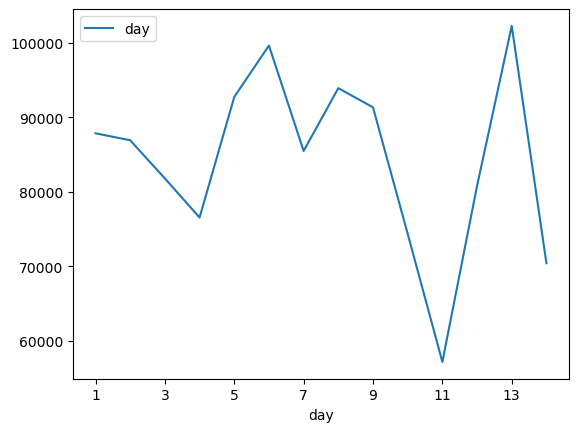

In [78]:
day_counts.plot.line(); #.get_figure().savefig('output/plots/day_counts.png')